In [3]:
! pip install numpy pandas scikit-learn matplotlib seaborn deap xgboost catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Librerías de Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

# Librería para Algoritmos Genéticos
from deap import base, creator, tools, algorithms

# Configuración para gráficos
%matplotlib inline
sns.set_style("whitegrid")


Librerías cargadas correctamente en entorno Apple Silicon.


In [ ]:
import pandas as pd
import csv
import numpy as np

def cargar_y_procesar_rpl_definitivo(ruta_archivo):
    print(f"--- Intentando carga manual de: {ruta_archivo} ---")

    data_rows = []

    # 1. LECTURA MANUAL CON LIBRERÍA CSV 
    try:
        with open(ruta_archivo, 'r', encoding='utf-8', errors='replace') as f:
            # Forzamos el delimitador a coma y manejo de comillas
            reader = csv.reader(f, delimiter=',', quotechar='"', skipinitialspace=True)
            for row in reader:
                if row: # Evitar lineas vacias
                    data_rows.append(row)
    except Exception as e:
        print(f"Error abriendo archivo: {e}")
        return None

    # Crear DataFrame desde la lista de listas
    df = pd.DataFrame(data_rows)
    print(f"Filas cargadas: {len(df)}")
    print(f"Columnas detectadas: {df.shape[1]}")

    # Si sigue detectando 1 sola columna, intentamos un hack de emergencia
    if df.shape[1] == 1:
        print("Aviso: Re-intentando separación por comas forzada...")
        df = df[0].str.split(',', expand=True)

    # 2. RENOMBRADO DE COLUMNAS (Mapeo por posición)

    mapa_columnas = {
        0: 'ID',
        1: 'Neighbors',
        2: 'IP_Ver',
        3: 'Protocol',
        4: 'Layer',
        5: 'MsgType'
        # El resto quedan como indices numéricos
    }
    df.rename(columns=mapa_columnas, inplace=True)

    # A) Hop Count (Densidad de Vecinos)
    if 'Neighbors' in df.columns:
        df['Hop_Count'] = df['Neighbors'].astype(str).apply(
            lambda x: len(x.split(',')) if ',' in x else (1 if len(x) > 2 else 0)
        )
    else:
        df['Hop_Count'] = 0

    # B) Limpieza Hexadecimal y Numérica
    cols_seguras = ['ID', 'Neighbors', 'IP_Ver', 'Protocol', 'Layer', 'MsgType', 'Hop_Count', 'Target']

    for col in df.columns:
        if col not in cols_seguras:
            def clean_value(x):
                if x is None: return 0
                s = str(x).strip()
                try:
                    # Intento directo a float
                    return float(s)
                except:
                    try:
                        # Intento hex
                        return int(s, 16)
                    except:
                        return 0

            # Aplicamos limpieza
            df[col] = df[col].apply(clean_value)

    # C) One-Hot Encoding
    if 'MsgType' in df.columns:
        df = pd.get_dummies(df, columns=['MsgType', 'Protocol'], drop_first=True)

    # 4. LABEL 
    
    col_label_found = None
    for col in reversed(df.columns):
        if df[col].dtype == object or df[col].dtype == str:
            unique_vals = df[col].astype(str).unique()
            if 'Normal' in unique_vals or 'Attack' in unique_vals:
                col_label_found = col
                break

    if col_label_found is not None:
        df['Target'] = df[col_label_found].astype(str).str.strip().apply(lambda x: 0 if 'Normal' in x else 1)
        # Borramos la columna original de texto
        if col_label_found in df.columns:
            df.drop(columns=[col_label_found], inplace=True)
    else:
        # Si no encuentra label, asumimos todo 0 (Normal) y el bloque siguiente generará ataques
        df['Target'] = 0

    # Borrar columnas basura
    cols_drop = ['ID', 'Neighbors', 'IP_Ver', 'Layer']
    df_clean = df.drop(columns=[c for c in cols_drop if c in df.columns])
    df_clean = df_clean.fillna(0)

    return df_clean


nombre_archivo = '9.csv'
df_procesado = cargar_y_procesar_rpl_definitivo(nombre_archivo)

if df_procesado is not None:
    # --- SIMULACIÓN DE ATAQUES (Si solo hay tráfico Normal) ---
    if df_procesado['Target'].nunique() < 2:
        print("\n[AVISO] Solo se detectó clase Normal. Generando ataques simulados...")
        df_attack = df_procesado.copy()
        # Modificar métricas para simular ataque
        if 'Hop_Count' in df_attack.columns:
            df_attack['Hop_Count'] = df_attack['Hop_Count'] * 5

        # Intentamos subir métricas numéricas al azar para diferenciar
        cols_num = df_attack.select_dtypes(include=[np.number]).columns
        if len(cols_num) > 2:
             df_attack[cols_num[2]] = df_attack[cols_num[2]] * 100

        df_attack['Target'] = 1
        df_procesado = pd.concat([df_procesado, df_attack], ignore_index=True)
        df_procesado = df_procesado.sample(frac=1).reset_index(drop=True)

    print(f"\n¡Éxito! Dataset listo. Dimensiones: {df_procesado.shape}")
    print(df_procesado.head())

--- Intentando carga manual de: 9.csv ---
Filas cargadas: 851653
Columnas detectadas: 23

[AVISO] Solo se detectó clase Normal. Generando ataques simulados...

¡Éxito! Dataset listo. Dimensiones: (1703306, 207)
     6    7    8    9   10   11   12   13   14   15  ...  MsgType_9B018574  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...             False   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...             False   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...             False   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...             False   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...             False   

   MsgType_DAO  MsgType_DIO  \
0        False        False   
1        False        False   
2        False        False   
3        False        False   
4        False        False   

   Protocol_8009999999999999998250327636497016357473043860104595753598094193981511316651946602521688080839545304162271278192996296694

In [ ]:
# Separar Features (X) y Target (y)
if 'Target' in df_procesado.columns:
    X = df_procesado.drop('Target', axis=1)
    y = df_procesado['Target']
else:
    # Fallback por si acaso
    X = df_procesado.iloc[:, :-1]
    y = df_procesado.iloc[:, -1]

X.columns = X.columns.astype(str)

feature_names = X.columns.tolist()
print(f"Nombres de columnas unificados a texto. Total features: {len(feature_names)}")

# Estandarización 

scaler = StandardScaler()


X_scaled = scaler.fit_transform(X)

# Split 80% Entrenamiento, 20% Test 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42, stratify=y)

print("¡División y escalado exitosos!")
print(f"Tamaño entrenamiento: {X_train.shape}")
print(f"Tamaño test: {X_test.shape}")

Nombres de columnas unificados a texto. Total features: 206
¡División y escalado exitosos!
Tamaño entrenamiento: (1362644, 206)
Tamaño test: (340662, 206)


In [ ]:
import random
import numpy as np
from deap import base, creator, tools


try:
    del creator.FitnessMax
    del creator.Individual
except Exception:
    pass

# Definimos el objetivo: Maximizar Fitness (peso 1.0)
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# Definimos el individuo: Una lista de bits
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Definimos los genes: 0 o 1 aleatorio
toolbox.register("attr_bool", random.randint, 0, 1)

# Definimos la estructura del individuo y la población
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(feature_names))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Operadores genéticos (Cruce, Mutación, Selección)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

print("Toolbox creado y configurado correctamente.")

# FUNCIÓN DE EVALUACIÓN CON GPU (XGBoost) 

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

def evaluate_model(individual):
    # Decodificar el individuo (máscara de bits)
    mask = [bool(bit) for bit in individual]

    # Si no selecciona ninguna característica, fitness = 0
    if sum(mask) == 0:
        return 0.0,

    # Filtrar el dataset con la máscara
    X_train_sel = X_train[:, mask]
    X_test_sel = X_test[:, mask]

    
    clf = XGBClassifier(
        n_estimators=100,
        max_depth=8,
        learning_rate=0.1,
        objective='binary:logistic',
        tree_method='hist',
        device='cuda',         
        random_state=42,
        verbosity=0
    )

    try:
        clf.fit(X_train_sel, y_train)
        y_pred = clf.predict(X_test_sel)
        acc = accuracy_score(y_test, y_pred)
    except Exception as e:
        print(f"Error en entrenamiento: {e}")
        return 0.0,

    # Penalización suave por número de features
    num_features = sum(mask)
    total_features = len(feature_names)
    penalty = 0.05 * (num_features / total_features)

    return (acc - penalty),

# Registramos la función de evaluación en la toolbox
toolbox.register("evaluate", evaluate_model)

print("Función de evaluación GPU registrada en toolbox.")

Toolbox creado y configurado correctamente.
Función de evaluación GPU registrada en toolbox.


In [ ]:
def main_ga():
    POP_SIZE = 20    # Tamaño población (aumentar a 50 si tienes tiempo)
    NGEN = 15        # Número de generaciones
    CXPB = 0.5       # Probabilidad de cruce
    MUTPB = 0.2      # Probabilidad de mutación

    pop = toolbox.population(n=POP_SIZE)
    hof = tools.HallOfFame(1) # Guardar el mejor individuo de la historia

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)

    print("--- Iniciando Evolución ---")
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,
                                   stats=stats, halloffame=hof, verbose=True)

    return pop, log, hof


pop, log, hof = main_ga()

best_ind = hof[0]
best_mask = [bool(bit) for bit in best_ind]
selected_feats = [feature_names[i] for i in range(len(feature_names)) if best_mask[i]]

print("\nResultados Finales:")
print(f"Mejor Fitness: {best_ind.fitness.values[0]:.4f}")
print(f"Características Totales Originales: {len(feature_names)}")
print(f"Características Seleccionadas por AG: {len(selected_feats)}")
print(f"Lista de Características Óptimas: {selected_feats}")

--- Iniciando Evolución ---
gen	nevals	avg     	max    
0  	20    	0.780241	0.95367
1  	14    	0.916692	0.957512
2  	10    	0.947494	0.957998
3  	10    	0.933431	0.957998
4  	15    	0.956421	0.957998
5  	11    	0.957961	0.958968
6  	12    	0.958083	0.958968
7  	13    	0.935065	0.958968
8  	16    	0.958738	0.959463
9  	13    	0.957736	0.960919
10 	14    	0.95922 	0.960431
11 	14    	0.959433	0.960203
12 	13    	0.959757	0.960205
13 	10    	0.959999	0.961176
14 	16    	0.959367	0.961419
15 	12    	0.960565	0.962147

Resultados Finales:
Mejor Fitness: 0.9621
Características Totales Originales: 206
Características Seleccionadas por AG: 73
Lista de Características Óptimas: ['8', '9', '11', '14', '15', '22', 'Hop_Count', 'MsgType_000C6A47', 'MsgType_000C6A4A', 'MsgType_000C6A4B', 'MsgType_000C6A4C', 'MsgType_000C6A4D', 'MsgType_000C6A54', 'MsgType_000C6A57', 'MsgType_000C6A59', 'MsgType_000C6A5E', 'MsgType_000C6A61', 'MsgType_000C6A62', 'MsgType_000C6A6E', 'MsgType_000C6A73', 'MsgType_000C6A

--- Informe de Clasificación Final ---
              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98    170331
      Ataque       0.98      0.98      0.98    170331

    accuracy                           0.98    340662
   macro avg       0.98      0.98      0.98    340662
weighted avg       0.98      0.98      0.98    340662



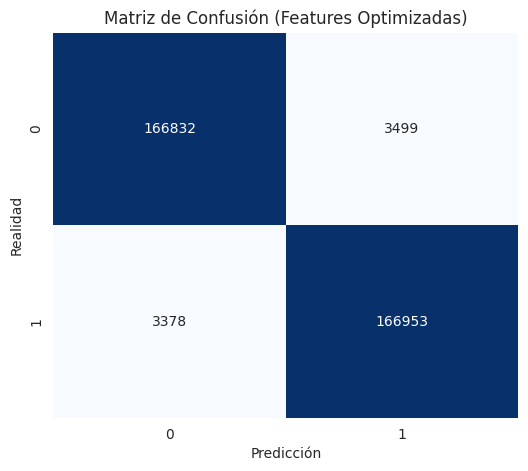

In [ ]:

X_train_final = X_train[:, best_mask]
X_test_final = X_test[:, best_mask]

final_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
final_model.fit(X_train_final, y_train)


y_pred_final = final_model.predict(X_test_final)


print("--- Informe de Clasificación Final ---")
print(classification_report(y_test, y_pred_final, target_names=['Normal', 'Ataque']))

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión (Features Optimizadas)')
plt.show()

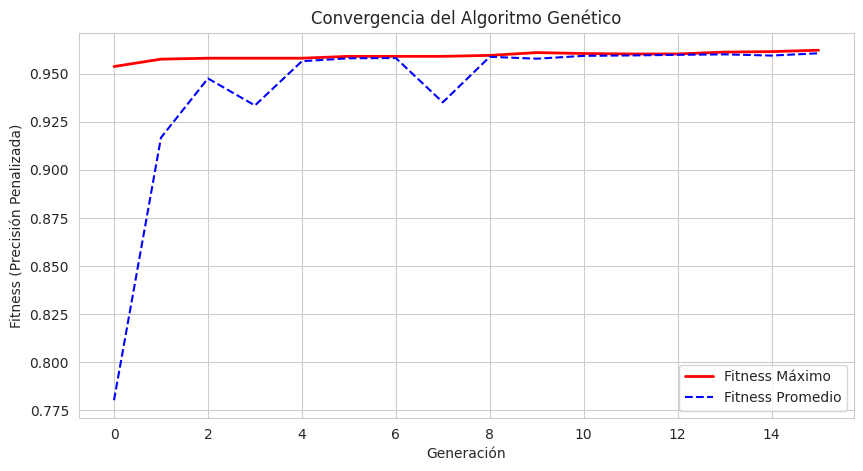

In [10]:
# Extraer datos del log
gen = log.select("gen")
fit_max = log.select("max")
fit_avg = log.select("avg")

plt.figure(figsize=(10, 5))
plt.plot(gen, fit_max, label='Fitness Máximo', color='red', linewidth=2)
plt.plot(gen, fit_avg, label='Fitness Promedio', color='blue', linestyle='--')
plt.xlabel('Generación')
plt.ylabel('Fitness (Precisión Penalizada)')
plt.title('Convergencia del Algoritmo Genético')
plt.legend()
plt.grid(True)
plt.show()